# Team Color Assignment using LAB Color Space
이 노트북은 LAB 색상 공간을 사용하여 조명에 강건한 팀 색상 추출을 시연합니다.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

## 1. 이미지 로드

Image shape: (64, 30, 3)
Top half shape: (32, 30, 3)


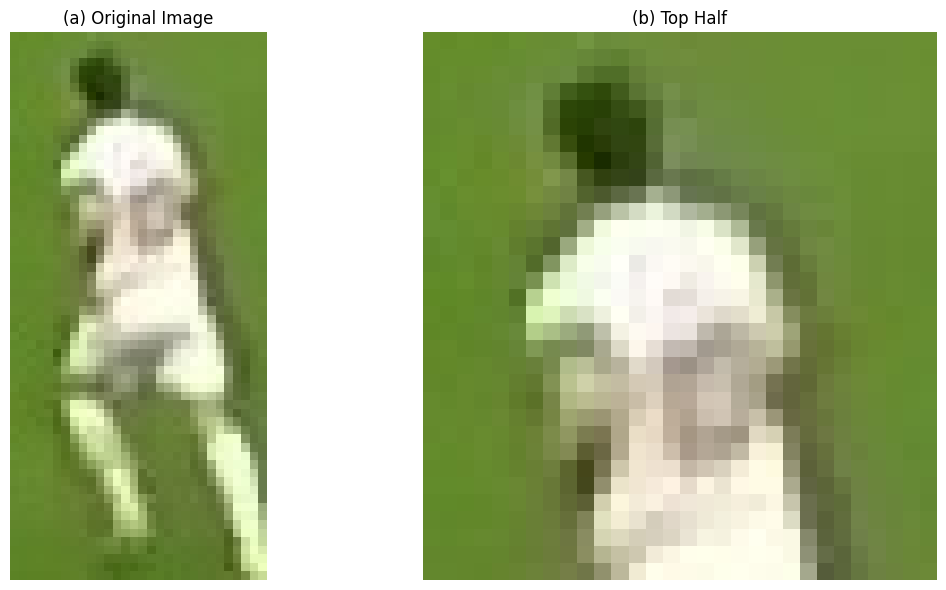

In [ ]:
# 이미지 로드
image_path = "E:/soccer/football_analysis/output_videos/crops/player_2_f0.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Image shape: {image.shape}")

# 상반부 50%만 사용 (유니폼 영역)
top_half = image[0:image.shape[0]//2, :]
top_half_rgb = cv2.cvtColor(top_half, cv2.COLOR_BGR2RGB)
print(f"Top half shape: {top_half.shape}")

# 1, 2 이미지를 한 figure에 나란히 표시
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
axes[0].imshow(image_rgb)
axes[0].set_title('(a) Original Image')
axes[0].axis('off')

# 상반부(top half)
axes[1].imshow(top_half_rgb)
axes[1].set_title('(b) Top Half')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 2. 상반신 영역만 추출 (유니폼 영역)

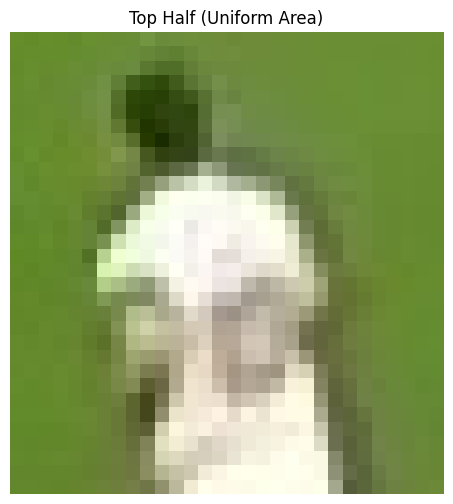

Top half shape: (32, 30, 3)


In [3]:
# 상반부 50%만 사용 (유니폼 영역)
top_half = image[0:image.shape[0]//2, :]
top_half_rgb = cv2.cvtColor(top_half, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(top_half_rgb)
plt.title('Top Half (Uniform Area)')
plt.axis('off')
plt.show()

print(f"Top half shape: {top_half.shape}")

## 3. HSV 색상 공간에서 잔디 제거

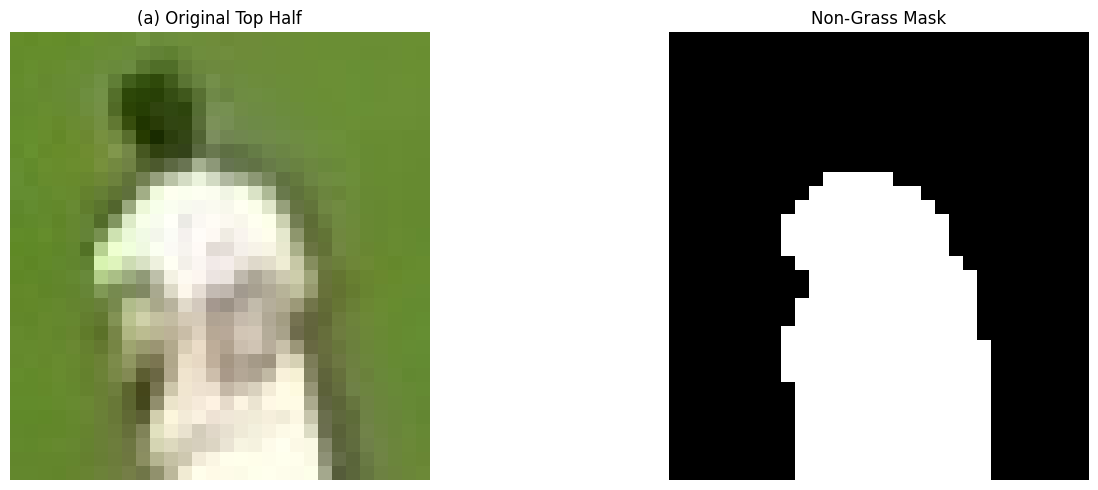

Non-grass pixels: 278


In [4]:
# HSV로 변환
hsv = cv2.cvtColor(top_half, cv2.COLOR_BGR2HSV)

# 잔디 영역 마스킹 (H: 35-85, S: 40-255, V: 40-255)
lower_grass = np.array([35, 40, 40])
upper_grass = np.array([85, 255, 255])
grass_mask = cv2.inRange(hsv, lower_grass, upper_grass)

# 잔디가 아닌 영역만 남기기
non_grass_mask = cv2.bitwise_not(grass_mask)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(top_half_rgb)
axes[0].set_title('(a) Original Top Half')
axes[0].axis('off')

axes[1].imshow(grass_mask, cmap='gray')
axes[1].set_title('Grass Mask (White = Grass)')
axes[1].axis('off')

axes[1].imshow(non_grass_mask, cmap='gray')
axes[1].set_title('Non-Grass Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 마스킹된 픽셀만 추출
pixels = top_half[non_grass_mask > 0]
print(f"Non-grass pixels: {len(pixels)}")

if len(pixels) < 30:
    print("[WARNING] Not enough pixels after grass removal!")

## 4. LAB 색상 공간으로 변환 (a, b 채널만 사용)

In [5]:
# BGR 픽셀을 LAB로 변환
lab_pixels = cv2.cvtColor(pixels.reshape(-1, 1, 3), cv2.COLOR_BGR2LAB).reshape(-1, 3)

# a, b 채널만 사용 (L 채널 제외 = 조명 불변)
ab_pixels = lab_pixels[:, 1:]  # (N, 2) shape

print(f"LAB pixels shape: {lab_pixels.shape}")
print(f"a, b pixels shape: {ab_pixels.shape}")
print(f"\na, b value ranges:")
print(f"  a: [{ab_pixels[:, 0].min():.1f}, {ab_pixels[:, 0].max():.1f}]")
print(f"  b: [{ab_pixels[:, 1].min():.1f}, {ab_pixels[:, 1].max():.1f}]")

LAB pixels shape: (278, 3)
a, b pixels shape: (278, 2)

a, b value ranges:
  a: [116.0, 131.0]
  b: [130.0, 156.0]


## 5. a, b 공간에서 k-means 클러스터링 (k=2)

In [6]:
# k-means 클러스터링 (k=2)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
labels = kmeans.fit_predict(ab_pixels)
centers_ab = kmeans.cluster_centers_  # (2, 2) shape

print(f"Cluster centers (a, b):")
print(f"  Cluster 0: a={centers_ab[0, 0]:.2f}, b={centers_ab[0, 1]:.2f}")
print(f"  Cluster 1: a={centers_ab[1, 0]:.2f}, b={centers_ab[1, 1]:.2f}")

# 각 클러스터의 픽셀 수
unique, counts = np.unique(labels, return_counts=True)
print(f"\nCluster pixel counts:")
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} pixels ({count/len(labels)*100:.1f}%)")

Cluster centers (a, b):
  Cluster 0: a=121.14, b=147.11
  Cluster 1: a=126.97, b=137.09

Cluster pixel counts:
  Cluster 0: 74 pixels (26.6%)
  Cluster 1: 204 pixels (73.4%)


## 6. Chroma 계산 및 유니폼 클러스터 선택

In [7]:
# Chroma 계산: C = sqrt(a^2 + b^2)
chroma = np.sqrt(centers_ab[:, 0]**2 + centers_ab[:, 1]**2)

print(f"Chroma values:")
print(f"  Cluster 0: C = {chroma[0]:.2f}")
print(f"  Cluster 1: C = {chroma[1]:.2f}")

# 채도(Chroma)가 높은 클러스터 = 유니폼
uniform_cluster = np.argmin(chroma)
skin_cluster = 1 - uniform_cluster

print(f"\n→ Uniform cluster: {uniform_cluster} (higher chroma)")
print(f"→ Skin cluster: {skin_cluster} (lower chroma)")

Chroma values:
  Cluster 0: C = 190.56
  Cluster 1: C = 186.86

→ Uniform cluster: 1 (higher chroma)
→ Skin cluster: 0 (lower chroma)


## 7. 시각화: 두 클러스터 분리

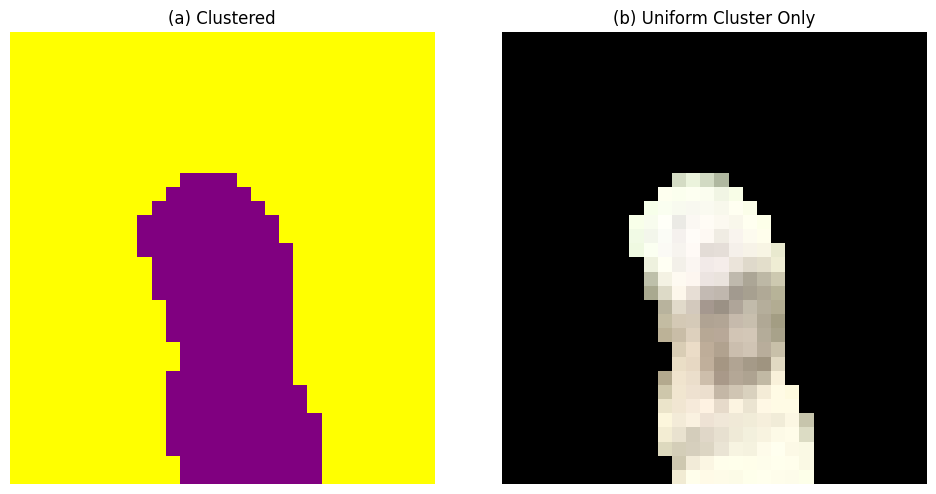

In [8]:
# 클러스터별로 원본 이미지에 마스크 생성
clustered_mask = np.zeros((top_half.shape[0], top_half.shape[1]), dtype=np.uint8)
clustered_mask[non_grass_mask > 0] = labels

# 각 클러스터를 다른 색으로 표시
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 원본
# axes[0].imshow(top_half_rgb)
# axes[0].set_title('Original Top Half')
# axes[0].axis('off')

# 클러스터 결과 (0=노랑, 1=보라)
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['yellow', 'purple'])
axes[0].imshow(clustered_mask, cmap=cmap)
axes[0].set_title(f'(a) Clustered')
axes[0].axis('off')

# 유니폼 클러스터만 표시
uniform_only = np.zeros_like(top_half_rgb)
uniform_only[clustered_mask == uniform_cluster] = top_half_rgb[clustered_mask == uniform_cluster]
axes[1].imshow(uniform_only)
axes[1].set_title('(b) Uniform Cluster Only')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 8. 최종 대표 색상 추출 (LAB → BGR)

In [9]:
# 유니폼 클러스터의 평균 LAB 값 계산
uniform_lab_pixels = lab_pixels[labels == uniform_cluster]
mean_lab = uniform_lab_pixels.mean(axis=0)

print(f"Mean LAB of uniform cluster:")
print(f"  L = {mean_lab[0]:.2f}")
print(f"  a = {mean_lab[1]:.2f}")
print(f"  b = {mean_lab[2]:.2f}")

# LAB → BGR 변환
mean_bgr = cv2.cvtColor(
    mean_lab.reshape(1, 1, 3).astype(np.uint8),
    cv2.COLOR_LAB2BGR
).reshape(3)

# BGR → RGB (시각화용)
mean_rgb = cv2.cvtColor(
    mean_lab.reshape(1, 1, 3).astype(np.uint8),
    cv2.COLOR_LAB2RGB
).reshape(3)

print(f"\nFinal representative color:")
print(f"  BGR: {mean_bgr}")
print(f"  RGB: {mean_rgb}")

Mean LAB of uniform cluster:
  L = 224.73
  a = 126.97
  b = 137.09

Final representative color:
  BGR: [203 221 224]
  RGB: [224 221 203]


## 9. 대표 색상 시각화

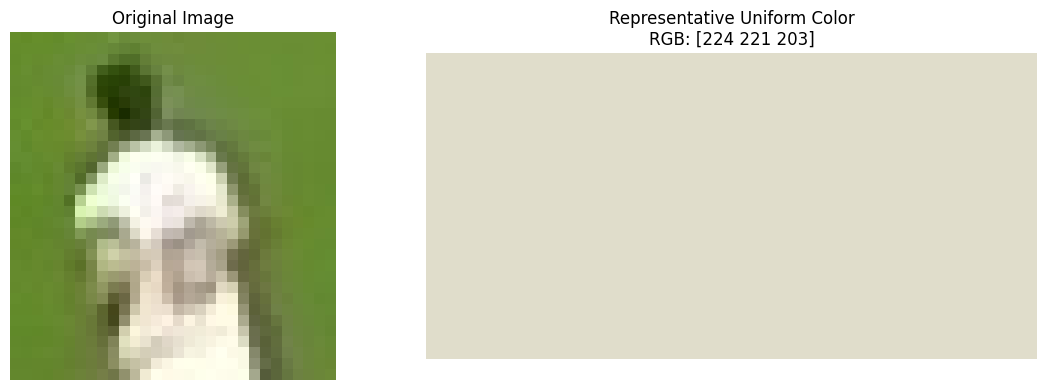

In [10]:
# 대표 색상을 큰 사각형으로 표시
color_swatch = np.ones((100, 200, 3), dtype=np.uint8)
color_swatch[:, :] = mean_rgb

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(top_half_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(color_swatch)
axes[1].set_title(f'Representative Uniform Color\nRGB: {mean_rgb}')
axes[1].axis('off')

plt.tight_layout()
plt.show()